In [1]:
## Neccessary Imports

import pandas as pd
import numpy as np

import re
import nltk

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Attention, Dropout, GlobalMaxPooling1D, Concatenate, Flatten 
from tensorflow.keras.models import Model

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
data = pd.read_csv("twitter-suicidal_data.csv")  # adjust filename as per your dataset
data.head()


,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


## Data Cleaning

In [3]:
# Download NLTK resources 
# nltk.download('stopwords')
# nltk.download('wordnet')

# Function for data cleaning
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    
    return text

In [4]:
# Apply data cleaning to the 'tweet' column
data['cleaned_tweet'] = data['tweet'].apply(clean_text)
data.head()

,tweet,intention,cleaned_tweet
0,my life is meaningless i just want to end my l...,1,life meaningless want end life badly life comp...
1,muttering i wanna die to myself daily for a fe...,1,muttering wanna die daily month feel worthless...
2,work slave i really feel like my only purpose ...,1,work slave really feel like purpose life make ...
3,i did something on the 2 of october i overdose...,1,something october overdosed felt alone horribl...
4,i feel like no one cares i just want to die ma...,1,feel like one care want die maybe feel le lonely


## Data Preprocessing and Data Spliting

In [5]:
# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['cleaned_tweet'])
sequences = tokenizer.texts_to_sequences(data['cleaned_tweet'])
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

In [6]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, data['intention'], test_size=0.25, random_state=42)

## Model Build and Training

In [7]:
# Build the model
max_sequence_length = 100
embedding_dim = 50
lstm_units = 64
dense_units = 32

input_layer = Input(shape=(max_sequence_length,), name='Input')
embedding_layer = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=embedding_dim,)(input_layer)
attention_layer = Attention()([embedding_layer, embedding_layer])
lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=True))(attention_layer)
attention_projection = Dense(128, activation='linear')(attention_layer)
attention_weighted_sum = Attention()([lstm_layer, attention_projection])
flattened_attention = Flatten()(attention_weighted_sum)
dense_layer = Dense(dense_units, activation='relu')(flattened_attention)
output_layer = Dense(1, activation='sigmoid', name='Output')(dense_layer)


model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 100)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 50)   │  1,096,250 │ Input[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 100, 50)   │          0 │ embedding[0][0],  │
│ (Attention)         │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 100, 128)  │     58,880 │ attention[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100, 128)  │      6,528 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 100, 128)  │          0 │ bidirectional[0]… │
│ (Attention)         │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12800)     │          0 │ attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │    409,632 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 1)         │         33 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,571,323 (5.99 MB)

 Trainable params: 1,571,323 (5.99 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.7715 - loss: 0.4648 - val_accuracy: 0.8867 - val_loss: 0.3053
Epoch 2/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.8714 - loss: 0.3270 - val_accuracy: 0.8794 - val_loss: 0.3023
Epoch 3/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8995 - loss: 0.2754 - val_accuracy: 0.9042 - val_loss: 0.2897
Epoch 4/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9118 - loss: 0.2523 - val_accuracy: 0.9042 - val_loss: 0.2610
Epoch 5/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9321 - loss: 0.2054 - val_accuracy: 0.8947 - val_loss: 0.2991
Epoch 6/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.9203 - loss: 0.2353 - val_accuracy: 0.9057 - val_loss: 0.2471
Epoch 7/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.9288 - loss: 0.1995 - val_accuracy: 0.9094 - val_loss: 0.2504
Epoch 8/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.9437 - loss: 0.1543 - 

## Plot the curve

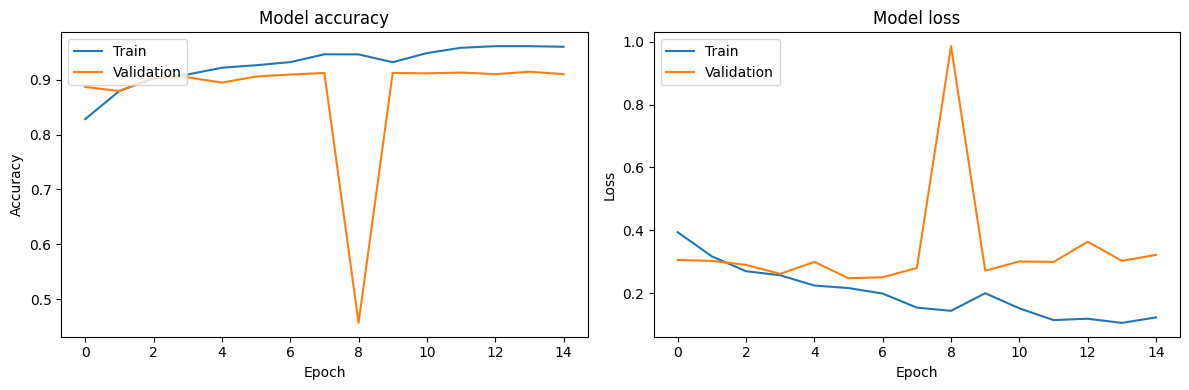

In [9]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


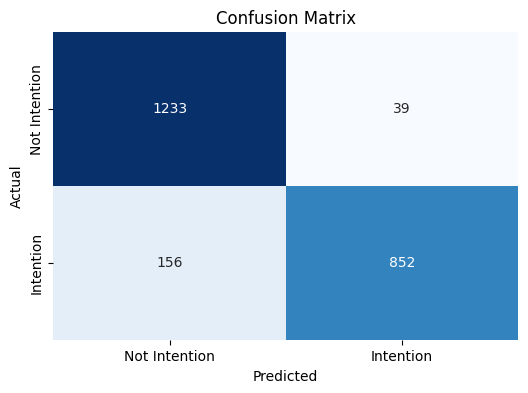

Accuracy Score: 0.9144736842105263
Precision Score: 0.9562289562289562


In [10]:
# Evaluate the model on the test set
y_pred = model.predict(X_test)

y_pred_classes = [1 if pred[0] > 0.5 else 0 for pred in y_pred]
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_classes), annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Intention', 'Intention'], yticklabels=['Not Intention', 'Intention'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print accuracy score
print(f"Accuracy Score: {accuracy}")
# Print precision score
print(f"Precision Score: {precision}")

## Prediction

In [11]:
# Find the optimal threshold from the validation set
thresholds = np.arange(0.1, 0.5, 0.02)
# Find the threshold that maximizes F1-score on the validation set
best_threshold = 0.5  # Default threshold
best_f1_score = 0.0

for threshold in thresholds:
    y_pred_classes = [1 if pred > threshold else 0 for pred in y_pred.ravel()]
    current_f1_score = f1_score(y_test, y_pred_classes[:len(y_test)])  # Ensure length consistency
    
    if current_f1_score > best_f1_score:
        best_f1_score = current_f1_score
        best_threshold = threshold
# Print the best threshold and F1-score
print(f"Best Threshold: {best_threshold}")
print(f"Best F1-Score: {best_f1_score}")

Best Threshold: 0.16000000000000003
Best F1-Score: 0.8996434029546613


In [12]:
# Example of a new tweet for prediction
new_tweet = ["i am 16 and hate myself so much i have very little friends an introvert never had a girlfriend been bullied a lot and rejected a lot please help me i dont deserve to be on this earth"]
happy = ["it is a very wonderfull day to start new work"]
# I wish i were dead. I wish I had not been born.i am 16 and hate myself so much i have very little friends an introvert never had a girlfriend been bullied a lot and rejected a lot please help me i dont deserve to be on this earth
# Clean the new tweet
cleaned_new_tweet = clean_text(new_tweet[0])
cleaned_happy_tweet =clean_text(happy[0])

# Tokenize and pad the sequence
new_sequence = tokenizer.texts_to_sequences([cleaned_new_tweet])
padded_new_sequence = pad_sequences(new_sequence, maxlen=100, padding='post', truncating='post')

happy_sequence = tokenizer.texts_to_sequences([cleaned_happy_tweet])
padded_happy_sequence = pad_sequences(happy_sequence, maxlen=100, padding='post', truncating='post')

# Make predictions
prediction = model.predict(padded_new_sequence)
prediction1 = model.predict(padded_happy_sequence)

# Interpret the prediction
prediction_class = 1 if prediction[0][0] > best_threshold else 0
prediction1_class = 1 if prediction1[0][0] > best_threshold else 0

# Display the result
print(f"Predicted Probability: {prediction[0][0]}")
print(f"Predicted Class: {'Intention' if prediction_class == 1 else 'Not Intention'}")

print(f"Predicted Probability: {prediction1[0][0]}")
print(f"Predicted Class: {'Intention' if prediction1_class == 1 else 'Not Intention'}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Probability: 0.946379542350769
Predicted Class: Intention
Predicted Probability: 0.002149173989892006
Predicted Class: Not Intention


In [13]:
# Evaluate the initial model on the test set
model_evaluation = model.evaluate(X_test, y_test)
print(f'Proposed Model - Test Accuracy: {model_evaluation[1]:.4f}')

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9155 - loss: 0.2989
Proposed Model - Test Accuracy: 0.9145
